## Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

The first part of this notebook walks through a typical harmonization process on data retrieved from Tampa Bay, FL. The second part of the notebook takes a deeper dive into exactly what is done to each water quality characteristic result and some ways to leverage additional functions in the package for special use cases.

### Simple workflow

#### import the required libraries. Check requirements.txt for additional dependencies to install.

In [1]:
# Use pip to install the package from github
#!pip install git+git://github.com/USEPA/harmonize-wq.git
#!pip install git+https://github.com/USEPA/harmonize-wq.git#egg=harmonize-wq

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
from harmonize_wq import location
from harmonize_wq import visualize

#### Create dataretrieval query using a polygon for Area Of Interest

<AxesSubplot:>

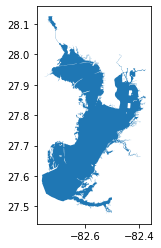

In [3]:
# Read geometry for Area of Interest from url to it in public repo
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# Note: alternatively you can direct it to a local shapefile
aoi_gdf = wrangle.as_gdf(aoi_url)
# Map aoi
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

#### Retrieve data

Stations and results meeting the query criteria are retrieved seperately. site_md and md_narrow are not used here but contain metadata to document and help reproduce the query/results in the future.

In [5]:
# Query for stations
stations, site_md = wqp.what_sites(**query)

In [6]:
# Query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,58,60,61,63,64,65,70,71,73) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Look at initial results (input)
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376882,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6895122,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376883,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843253,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376884,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843256,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376885,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6843653,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


#### Harmonize data using defaults

In [8]:
# Harmonize it and look at how it changed (output)
# Note: although we ignore unit dimensionality errors, it will warn when they are encountered and there are a lot of them
df_harmonized = harmonize.harmonize_all(df, errors='ignore')
df_harmonized

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
D:\code\harmonize-wq\harmonize_wq\harmonize.py:155: UserWarning: WARNING: 'percent' UNDEFINED UNIT for Phosphorus
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Bed_Sediment_Phosphorus" column for Bed Sediment, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Unfiltered_Phosphorus" column for Unfiltered, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Non-filterable_Phosphorus" column for Non-filterable, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Suspended_Phosphorus" column for Suspended, may be error
  warn('Warning: ' + prob

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,Chlorophyll,Salinity,Conductivity,Fecal_Coliform,E_coli,Turbidity,Temperature,Secchi,pH,DO
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.32 milligram / liter
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,40.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.19 degree_Celsius,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.48 dimensionless,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376882,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6895122,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7 dimensionless,NaN
1376883,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843253,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.7 degree_Celsius,NaN,NaN,NaN
1376884,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843256,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8 dimensionless,NaN
1376885,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6843653,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.1 degree_Celsius,NaN,NaN,NaN


In [9]:
# Harmonize and clip sample locations
gdf_harmonized = location.harmonize_locations(stations)  # Harmonize

In [10]:
stations_clipped = wrangle.clip_stations(gdf_harmonized, aoi_gdf)  # Clip to area of interest

<AxesSubplot:>

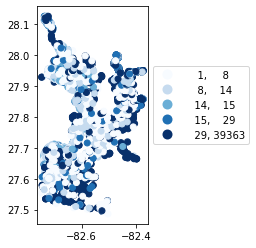

In [11]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_harmonized, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

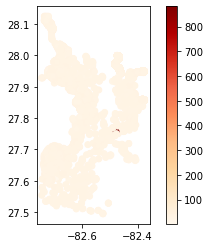

In [12]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_harmonized, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Clean additional columns of data

In [13]:
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


#### Reduce data to the columns that are most commonly needed

There are many columns in the dataframe that are characteristic specific, that is they have different values for the same sample depending on the characteristic. To ensure one result for each sample after the transformation of the data these columns must either be split, generating a new column for each characteristic with values, or moved out from the table if not being used.

In [14]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df_expanded = wrangle.split_col(df_cleaned)
df_expanded

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_Chlorophyll,QA_Salinity,QA_Conductivity,QA_Fecal_Coliform,QA_E_coli,QA_Turbidity,QA_Temperature,QA_Secchi,QA_pH,QA_DO
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,NaN,Dissolved oxygen (DO),Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,NaN,Salinity,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,NaN,Organic carbon,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376882,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,USGS-02306001,NWIS-6895122,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376883,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6843253,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376884,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6843256,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376885,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,USGS-274455082253601,NWIS-6843653,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Split table into main with columns of interest and characteristic specific columns/metadata
#116 columns into 47 and 69
main_df, chars_df = wrangle.split_table(df_expanded)

In [16]:
# Drop empty columns (QA columns without flags)
main_df_small = main_df.dropna(axis=1, how='all')

#### Transform data from long to wide format

In [17]:
transformed_df = wrangle.collapse_results(main_df_small)

Results are collapsed by retaining the first result that isn't NAN. There can be several reasons for multiple results for the same parameter/characteristic sampled at the same station, time and by the same organization. The collapse_results function assumes the user has already reviewed the quality of all results and narrowed down instances of multiple results to only the desired/best/highest quality result before running this function.

### Detailed step-by-step workflow

#### Download location data using dataretrieval

In [18]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [19]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [20]:
# Rows and columns for results
stations.shape

(15167, 37)

In [21]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [22]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [23]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [24]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [25]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(15167, 42)

In [26]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [27]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [28]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

<AxesSubplot:>

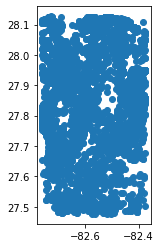

In [29]:
# Map it
stations_gdf.plot()

In [30]:
# Clip it to area of interest
aoi_gdf.to_crs(4326, inplace=True)
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<AxesSubplot:>

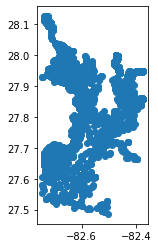

In [31]:
# Map it
stations_clipped.plot()

In [32]:
# How many stations now?
len(stations_clipped)

9972

In [33]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [34]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,33,36,38,58,60,61,63,64,65,70,71,73) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376882,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6895122,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376883,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843253,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376884,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6843256,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1376885,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6843653,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<AxesSubplot:>

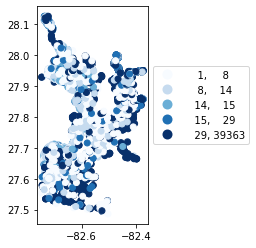

In [36]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [37]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize_generic?

##### secchi disk depth

D:\code\harmonize-wq\harmonize_wq\harmonize.py:155: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    79394.000000
mean         1.470750
std          0.899446
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 164
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.867423887235477): 45


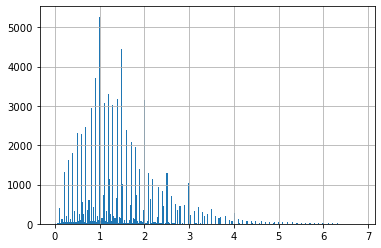

In [38]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [39]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
78,21FLHILL_WQX-171,0.60,m,NaN,m,0.6 meter
103,21FLHILL_WQX-092,5.00,m,NaN,m,5.0 meter
118,21FLHILL_WQX-161,0.50,m,NaN,m,0.5 meter
130,21FLHILL_WQX-14434,1.30,m,NaN,m,1.3 meter
132,21FLCOSP_WQX-COSPE6-4,2.6,m,NaN,m,2.6 meter
...,...,...,...,...,...,...
1376531,21FLHILL_WQX-32,3.5,m,NaN,m,3.5 meter
1376541,21FLHILL_WQX-610,0.3,m,NaN,m,0.3 meter
1376547,21FLPDEM_WQX-W6-B-21-08,1.874,m,NaN,m,1.874 meter
1376552,21FLPDEM_WQX-E2-D-21-08,0.9,m,NaN,m,0.9 meter


In [40]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
739437,21FLKWAT_WQX-HIL-PRETTY-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
743629,21FLKWAT_WQX-HIL-PRETTY-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
754584,21FLKWAT_WQX-HIL-FLYNN-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
766105,21FLKWAT_WQX-HIL-PRETTY-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
774182,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1357364,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357701,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357706,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357895,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [41]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [42]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
303392,NARS_WQX-NCCA10-1674,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
739437,21FLKWAT_WQX-HIL-PRETTY-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
743629,21FLKWAT_WQX-HIL-PRETTY-3,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
754584,21FLKWAT_WQX-HIL-FLYNN-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
766105,21FLKWAT_WQX-HIL-PRETTY-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1357364,USGS-273631082452600,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357701,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357706,USGS-275100082280500,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1357895,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


All these were missing both a value and unit so nothing could be done

In [43]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
10891,USGS-280630082350900,3,1.966667
10892,USGS-280635082322100,2,2.100000
10893,USGS-280640082434700,3,2.302933
10894,USGS-280719082291400,2,1.000000


D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

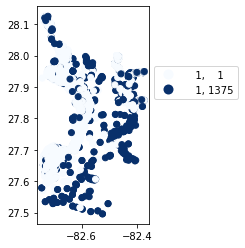

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

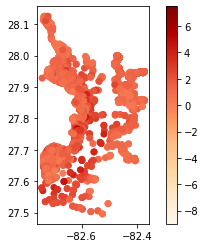

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    284315.000000
mean         25.306150
std          82.072548
min           0.000000
25%          21.180000
50%          25.910000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 66
Usable results with inferred units: 0
Results outside threshold (0.0 to 517.7414355978229): 1


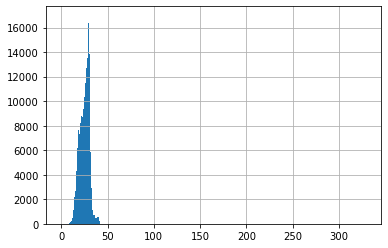

In [46]:
#'Temperature, water'
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True)

In [47]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
23,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
25,21FLHILL_WQX-060,30.24,deg C,NaN,30.24 degree_Celsius,degC
27,21FLTBW_WQX-NAB,30.67,deg C,NaN,30.67 degree_Celsius,degC
28,21FLTBW_WQX-DISM,26.5,deg C,NaN,26.5 degree_Celsius,degC
...,...,...,...,...,...,...
1376871,USGS-273217082335701,28.9,deg C,NaN,28.9 degree_Celsius,degC
1376874,USGS-274322082245501,24.4,deg C,NaN,24.4 degree_Celsius,degC
1376878,USGS-274302082280801,25.0,deg C,NaN,25.0 degree_Celsius,degC
1376883,USGS-273926082304501,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [48]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
734610,21FLPDEM_WQX-12-02,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
735844,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738472,21FLPDEM_WQX-05-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738736,21FLPDEM_WQX-22-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738771,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1115847,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1260433,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1318477,21FLPDEM_WQX-19-10,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1354959,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [49]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [50]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
734610,21FLPDEM_WQX-12-02,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
735844,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738472,21FLPDEM_WQX-05-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738736,21FLPDEM_WQX-22-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
738771,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1115847,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1260433,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1318477,21FLPDEM_WQX-19-10,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1354959,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [51]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
13964,USGS-280726082313300,4,28.025000
13965,USGS-280728082301101,54,25.083333
13966,USGS-280729082313501,1,27.400000
13967,USGS-280730082313201,1,24.700000


D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

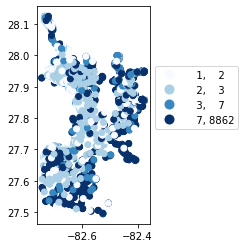

In [52]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

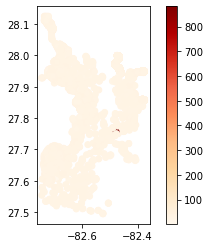

In [53]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [54]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [55]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/l,NaN,9.32 milligram / liter
9,21FLHILL_WQX-1611,4.90,mg/l,NaN,4.9 milligram / liter
11,21FLHILL_WQX-1606,2.56,mg/l,NaN,2.56 milligram / liter
14,21FLPDEM_WQX-24-01,68.7,%,NaN,5.676222371166 milligram / liter
19,21FLTBW_WQX-DISN,6.36,mg/l,NaN,6.36 milligram / liter
...,...,...,...,...,...
1376551,21FLHILL_WQX-1615,5.27,mg/l,NaN,5.27 milligram / liter
1376555,21FLHILL_WQX-74,4.78,mg/l,NaN,4.78 milligram / liter
1376557,21FLHILL_WQX-50,5.75,mg/l,NaN,5.75 milligram / liter
1376569,21FLHILL_WQX-180,5.16,mg/l,NaN,5.16 milligram / liter


In [56]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
14,21FLPDEM_WQX-24-01,68.7,%,NaN,5.676222371166 milligram / liter
166,21FLPDEM_WQX-W8-D-13-06,98,%,NaN,8.09708576964 milligram / liter
221,21FLPDEM_WQX-W5-A-13-01,79.4,%,NaN,6.560291939892 milligram / liter
252,21FLPDEM_WQX-19-09,76.3,%,NaN,6.304159634934 milligram / liter
312,21FLPDEM_WQX-W7-A-13-03,106,%,NaN,8.75807236308 milligram / liter
...,...,...,...,...,...
1108506,21FLPDEM_WQX-13-05,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1110519,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1110655,21FLPDEM_WQX-06-06,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1113844,21FLPDEM_WQX-12-02,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [57]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
12540,NARS_WQX-NCCA10-1672,8,5.437500
12541,NARS_WQX-NCCA10-1673,20,4.115000
12542,NARS_WQX-NCCA10-1674,6,2.466667
12543,NARS_WQX-NLA06608-0161,5,6.500000


D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

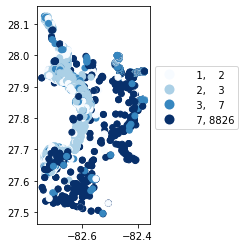

In [58]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

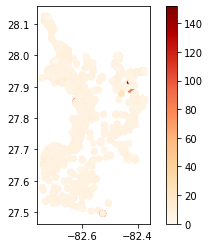

In [59]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    260652.000000
mean          7.767352
std           0.470477
min           0.370000
25%           7.540000
50%           7.900000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 73
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.59021371503252): 7


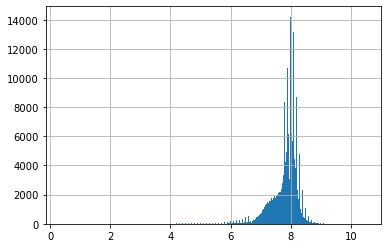

In [60]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [61]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,None,NaN,7.48 dimensionless
5,8.18,None,NaN,8.18 dimensionless
7,7.81,None,NaN,7.81 dimensionless
12,7.92,None,NaN,7.92 dimensionless
13,7.8,None,NaN,7.8 dimensionless
...,...,...,...,...
1376880,6.8,std units,NaN,6.8 dimensionless
1376881,7.3,std units,NaN,7.3 dimensionless
1376882,7.7,std units,NaN,7.7 dimensionless
1376884,7.8,std units,NaN,7.8 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    251908.000000
mean         22.007564
std          98.146406
min          -0.020000
25%          18.650000
50%          25.000000
75%          28.790000
max       48930.000000
dtype: float64
Unusable results: 1165
Usable results with inferred units: 0
Results outside threshold (0.0 to 610.886002518654): 4


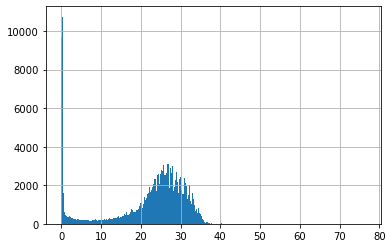

In [62]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [63]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
15,0.18,ppth,NaN,0.18 Practical_Salinity_Units
17,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1376578,1.66,ppth,NaN,1.66 Practical_Salinity_Units
1376579,15.44,ppth,NaN,15.44 Practical_Salinity_Units
1376583,29.5,ppth,NaN,29.5 Practical_Salinity_Units
1376589,15.24,ppth,NaN,15.24 Practical_Salinity_Units


###### Nitrogen

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579048): 0


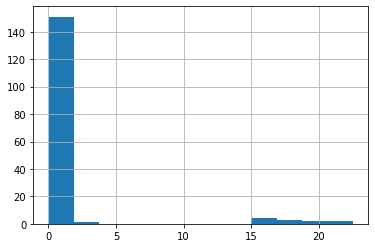

In [64]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [65]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
280847,0.39,mg/l,NaN,0.39 milligram / liter
296942,0.4475,mg/l,NaN,0.4475 milligram / liter
299710,0.425,mg/l,NaN,0.425 milligram / liter
313288,0.4625,mg/l,NaN,0.4625 milligram / liter
314893,0.33625,mg/l,NaN,0.33625 milligram / liter
...,...,...,...,...
1371572,0.084,mg/l,NaN,0.084 milligram / liter
1371580,0.166,mg/l,NaN,0.166 milligram / liter
1371590,0.091,mg/l,NaN,0.091 milligram / liter
1371624,0.057,mg/l,NaN,0.057 milligram / liter


###### Conductivity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     10.000000
mean     703.700000
std       79.037333
min      606.000000
25%      627.750000
50%      731.500000
75%      775.750000
max      776.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 1177.9239977057257): 0


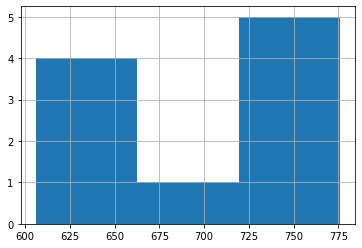

In [66]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

Note: No report because too few results

In [67]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
394014,775,uS/cm,NaN,775.0 microsiemens / centimeter
396762,776,uS/cm,NaN,776.0 microsiemens / centimeter
397732,776,uS/cm,NaN,776.0 microsiemens / centimeter
399843,776,uS/cm,NaN,776.0 microsiemens / centimeter
405118,775,uS/cm,NaN,775.0 microsiemens / centimeter
540640,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
545756,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
546804,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
549384,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
549800,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN


###### Chlorophyll a

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    43859.000000
mean         0.014293
std          0.022686
min         -0.003000
25%          0.004510
50%          0.008670
75%          0.016290
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.15041190114990327): 207


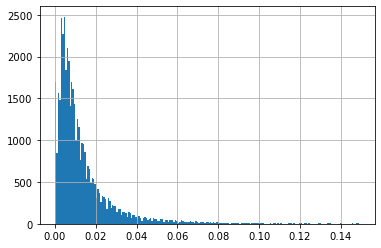

In [68]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
273061,4.1,mg/m3,NaN,0.0041 milligram / liter
273090,4,mg/m3,NaN,0.004000000000000001 milligram / liter
273091,45.5,mg/m3,NaN,0.04550000000000001 milligram / liter
273102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
273113,2.5,mg/m3,NaN,0.0025000000000000005 milligram / liter
...,...,...,...,...
1374354,18.16,ug/l,NaN,0.01816 milligram / liter
1374355,41.09,ug/l,NaN,0.04109 milligram / liter
1374366,23.55,ug/l,NaN,0.02355 milligram / liter
1374368,37.07,ug/l,NaN,0.03707 milligram / liter


###### Organic Carbon

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    1.894200e+04
mean     2.804181e+04
std      2.033080e+06
min      0.000000e+00
25%      4.500000e+00
50%      7.100000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1909
Usable results with inferred units: 0
Results outside threshold (0.0 to 12226523.0091774): 8


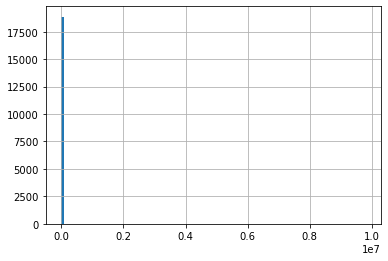

In [70]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/l,NaN,3.8 milligram / liter
68,28.0,mg/l,NaN,28.0 milligram / liter
272,3.4,mg/l,NaN,3.4 milligram / liter
287,6.7,mg/l,NaN,6.7 milligram / liter
346,5.8,mg/l,NaN,5.8 milligram / liter
...,...,...,...,...
1376510,11.9,mg/l,NaN,11.9 milligram / liter
1376545,4.4,mg/l,NaN,4.4 milligram / liter
1376549,3.9,mg/l,NaN,3.9 milligram / liter
1376587,23.4,mg/l,NaN,23.4 milligram / liter


###### Turbidity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     87515.000000
mean         16.776686
std         895.605508
min          -0.047700
25%           1.500000
50%           2.500000
75%           4.100000
max      200000.000000
dtype: float64
Unusable results: 1004
Usable results with inferred units: 0
Results outside threshold (0.0 to 5390.409736632069): 154


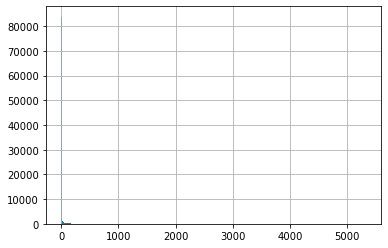

In [72]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [73]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
120,2.3,NTU,NaN,2.3 Nephelometric_Turbidity_Units
143,2.6,NTU,NaN,2.6 Nephelometric_Turbidity_Units
284,0.9,NTU,NaN,0.9 Nephelometric_Turbidity_Units
296,3.0,NTU,NaN,3.0 Nephelometric_Turbidity_Units
313,2.0,NTU,NaN,2.0 Nephelometric_Turbidity_Units
...,...,...,...,...
1376466,2.7,NTU,NaN,2.7 Nephelometric_Turbidity_Units
1376495,4.4,NTU,NaN,4.4 Nephelometric_Turbidity_Units
1376523,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
1376553,2.3,NTU,NaN,2.3 Nephelometric_Turbidity_Units


###### Sediment

In [74]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [75]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
1344863,28.0,%,NaN,280.0 gram / kilogram
1344864,38.0,%,NaN,380.0 gram / kilogram
1357044,97.0,%,NaN,970.0 gram / kilogram
1357045,99.0,%,NaN,990.0 gram / kilogram
1357046,100.0,%,NaN,1000.0 gram / kilogram
1357047,100.0,%,NaN,1000.0 gram / kilogram
1357048,100.0,%,NaN,1000.0 gram / kilogram
1357049,100.0,%,NaN,1000.0 gram / kilogram
1369653,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [76]:
# Phosphorus
# Note: must be merged w/ activities (package runs query by site if not already merged)
df = harmonize.harmonize_generic(df, 'Phosphorus')

D:\code\harmonize-wq\harmonize_wq\harmonize.py:155: UserWarning: WARNING: 'percent' UNDEFINED UNIT for Phosphorus
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Bed_Sediment_Phosphorus" column for Bed Sediment, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Unfiltered_Phosphorus" column for Unfiltered, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Non-filterable_Phosphorus" column for Non-filterable, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:433: UserWarning: Warning: "Suspended_Phosphorus" column for Suspended, may be error
  warn('Warning: ' + prob

Note the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [77]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
15344,0.003,mg/l,NaN,0.003 milligram / liter
19523,0.050,mg/l,NaN,0.05 milligram / liter
29589,0.009,mg/l,NaN,0.009 milligram / liter
178778,0.050,mg/l,NaN,0.05 milligram / liter
183932,0.002,mg/l,NaN,0.002 milligram / liter
...,...,...,...,...
1361530,0.2,mg/l as P,NaN,0.2 milligram / liter
1361535,0.22,mg/l as P,NaN,0.22 milligram / liter
1361560,0.18,mg/l as P,NaN,0.18 milligram / liter
1361563,0.33,mg/l as P,NaN,0.33 milligram / liter


In [78]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TP_Phosphorus
3378,0.049,mg/l,NaN,0.049 milligram / liter
9147,0.049,mg/l,NaN,0.049 milligram / liter
10615,0.004,mg/l,NaN,0.004 milligram / liter
10948,0.036,mg/l,NaN,0.036 milligram / liter
12030,0.053,mg/l,NaN,0.053 milligram / liter
...,...,...,...,...
1376459,0.162,mg/l,NaN,0.162 milligram / liter
1376505,0.153,mg/l,NaN,0.153 milligram / liter
1376528,0.185,mg/l,NaN,0.185 milligram / liter
1376561,0.116,mg/l,NaN,0.116 milligram / liter


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    3.912500e+04
mean     1.366509e+03
std      6.202050e+04
min      0.000000e+00
25%      5.000000e+00
50%      2.200000e+01
75%      1.800000e+02
max      1.000000e+07
dtype: float64
Unusable results: 23367
Usable results with inferred units: 5
Results outside threshold (0.0 to 373489.5029052042): 18


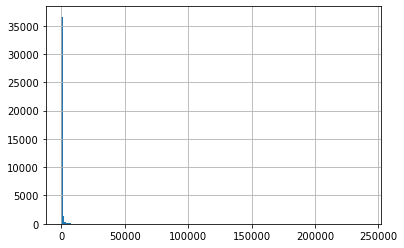

In [79]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [80]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
10,760,cfu/100ml,NaN,760.0 Colony_Forming_Units / milliliter
31,300,#/100ml,NaN,300.0 Colony_Forming_Units / milliliter
41,280,#/100ml,NaN,280.0 Colony_Forming_Units / milliliter
62,5,cfu/100ml,NaN,5.0 Colony_Forming_Units / milliliter
65,260,#/100ml,NaN,260.0 Colony_Forming_Units / milliliter
...,...,...,...,...
1376417,1.0,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter
1376491,156.0,cfu/100ml,NaN,156.0 Colony_Forming_Units / milliliter
1376511,2600.0,cfu/100ml,NaN,2600.0 Colony_Forming_Units / milliliter
1376582,1.0,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter


###### Escherichia coli

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     3827.000000
mean       734.305932
std       1941.042641
min          0.000000
25%         80.000000
50%        250.000000
75%        640.000000
max      41000.000000
dtype: float64
Unusable results: 336
Usable results with inferred units: 0
Results outside threshold (0.0 to 12380.561776238974): 21


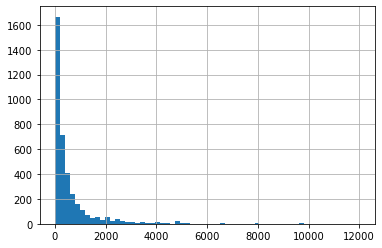

In [81]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True)

In [82]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
407283,28,MPN/100ml,NaN,28.0 Colony_Forming_Units / milliliter
408022,250,MPN/100ml,NaN,250.0 Colony_Forming_Units / milliliter
408112,580,MPN/100ml,NaN,580.0 Colony_Forming_Units / milliliter
408424,93,MPN/100ml,NaN,93.0 Colony_Forming_Units / milliliter
414635,1000.0,MPN/100ml,NaN,1000.0 Colony_Forming_Units / milliliter
...,...,...,...,...
1376278,92.0,cfu/100ml,NaN,92.0 Colony_Forming_Units / milliliter
1376287,8.0,cfu/100ml,NaN,8.0 Colony_Forming_Units / milliliter
1376345,9000.0,cfu/100ml,NaN,9000.0 Colony_Forming_Units / milliliter
1376489,20.0,cfu/100ml,NaN,20.0 Colony_Forming_Units / milliliter


### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Start by exploring Salinity results.

In [83]:
#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(convert.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [84]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 251908 
Mean: 22.00756371929444 PSU


In [85]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [86]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

In [87]:
# Look at important fields for max value
salinity_series = df['Salinity'][df['Salinity'].notna()]
x = max(salinity_series)
idx = df[df['Salinity']==x].index
df[cols][df['Salinity']==x]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
502766,48930,ppth,NaN,48930.0 Practical_Salinity_Units


In [88]:
# Look at important fields for second max value
x2 = max(salinity_series.drop(index=idx))
df[cols][df['Salinity']==x2]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
581713,2976,ppth,NaN,2976.0 Practical_Salinity_Units


Nothing jumps out as problematic for either value, though first is clearly an outlier

In [89]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

394014    775.0 microsiemens / centimeter
396762    776.0 microsiemens / centimeter
397732    776.0 microsiemens / centimeter
399843    776.0 microsiemens / centimeter
405118    775.0 microsiemens / centimeter
630150    626.0 microsiemens / centimeter
634771    688.0 microsiemens / centimeter
652326    606.0 microsiemens / centimeter
653188    606.0 microsiemens / centimeter
656303    633.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm. The values we have are well within that.

In [90]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
394014,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
396762,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
397732,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
399843,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
405118,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
630150,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
634771,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
652326,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
653188,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
656303,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter


In [100]:
# Original series values
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
cond_series

394014    775.0 microsiemens / centimeter
396762    776.0 microsiemens / centimeter
397732    776.0 microsiemens / centimeter
399843    776.0 microsiemens / centimeter
405118    775.0 microsiemens / centimeter
630150    626.0 microsiemens / centimeter
634771    688.0 microsiemens / centimeter
652326    606.0 microsiemens / centimeter
653188    606.0 microsiemens / centimeter
656303    633.0 microsiemens / centimeter
Name: Conductivity, dtype: object

In [101]:
# Convert values to PSU and write to Salinity
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), ['Salinity', 'Conductivity']]

,Salinity,Conductivity
394014,0.379 dimensionless,775.0 microsiemens / centimeter
396762,0.379 dimensionless,776.0 microsiemens / centimeter
397732,0.379 dimensionless,776.0 microsiemens / centimeter
399843,0.379 dimensionless,776.0 microsiemens / centimeter
405118,0.379 dimensionless,775.0 microsiemens / centimeter
630150,0.304 dimensionless,626.0 microsiemens / centimeter
634771,0.335 dimensionless,688.0 microsiemens / centimeter
652326,0.294 dimensionless,606.0 microsiemens / centimeter
653188,0.294 dimensionless,606.0 microsiemens / centimeter
656303,0.308 dimensionless,633.0 microsiemens / centimeter


### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [102]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-06-12,11:01:00,EST
1,2013-11-19,14:01:00,EST
2,2013-07-02,11:01:00,EST
3,2013-07-16,11:01:00,EST
4,2013-12-16,12:01:00,EST
...,...,...,...
1376882,1957-10-21,14:05:00,EST
1376883,1955-04-08,NaN,NaN
1376884,1955-04-08,NaN,NaN
1376885,1955-04-08,NaN,NaN


In [103]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-06-12,2013-06-12 16:01:00+00:00
1,2013-11-19,2013-11-19 19:01:00+00:00
2,2013-07-02,2013-07-02 16:01:00+00:00
3,2013-07-16,2013-07-16 16:01:00+00:00
4,2013-12-16,2013-12-16 17:01:00+00:00
...,...,...
1376882,1957-10-21,1957-10-21 19:05:00+00:00
1376883,1955-04-08,NaT
1376884,1955-04-08,NaT
1376885,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

### Characteristic to Column (long to wide format)

In [104]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_Chlorophyll,QA_Salinity,QA_Conductivity,QA_Fecal_Coliform,QA_E_coli,QA_Turbidity,QA_Temperature,QA_Secchi,QA_pH,QA_DO
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,NaN,Dissolved oxygen (DO),Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,NaN,Salinity,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,NaN,Organic carbon,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376882,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,USGS-02306001,NWIS-6895122,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376883,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6843253,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376884,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6843256,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1376885,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,USGS-274455082253601,NWIS-6843653,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

17 new columns


In [106]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

30049 fewer rows


In [107]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [108]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [109]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Other_Phosphorus', 'Bed_Sediment_Phosphorus', 'Unfiltered_Phosphorus',
       'Fecal_Coliform', 'E_coli', 'StartDate', 'Activity_datetime',
       'QA_Carbon', 'QA_Nitrogen', 'QA_Sediment', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Bed_Sediment_Phosphorus', 'QA_Unfiltered_Phosphorus',
       'QA_Chlorophyll', 'QA_Salinity', 'QA_Conductivity', 'QA_Fecal_Coliform',
       'QA_E_coli', 'QA_Turbidity', 'QA_Temperature', 'QA_Secchi', 'QA_pH',
       'QA_DO', 'Depth'],
      dtype='object')

In [110]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Salinity,QA_Conductivity,QA_Fecal_Coliform,QA_E_coli,QA_Turbidity,QA_Temperature,QA_Secchi,QA_pH,QA_DO,Depth
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,21FLHILL_WQX-585,STORET,NaN,NaN,9.32 milligram / liter,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,21FLSEAS_WQX-48SEAS190,STORET,NaN,NaN,NaN,NaN,40.0 Practical_Salinity_Units,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,21FLHILL_WQX-047,STORET,NaN,28.19 degree_Celsius,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,21FLHILL_WQX-112,STORET,NaN,NaN,NaN,7.48 dimensionless,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_Carbon',
 'QA_Nitrogen',
 'QA_Sediment',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Unfiltered_Phosphorus',
 'QA_Salinity',
 'QA_Conductivity',
 'QA_E_coli',
 'QA_Turbidity',
 'QA_Temperature',
 'QA_pH',
 'QA_DO']

<AxesSubplot:>

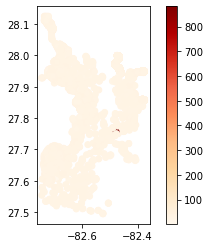

In [112]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)